In [1]:
import os
import os.path as op
import boto3
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import skimage.filters
from skimage.filters import try_all_threshold
from diff_classifier import aws
import matplotlib.image as mpimg
from scipy import ndimage as ndi
from skimage.transform import resize
import numpy.ma as ma

In [2]:
s3_bucket = 'mckenna.data'
s3_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
s3_img_filename = '{}_z_stack_MaxIP.tif'.format(prefix)
s3_feat_filename = "features_{}.csv".format(prefix)
aws.download_s3('{}/{}'.format(s3_folder,s3_feat_filename), s3_feat_filename, bucket_name=s3_bucket)
feat_name = s3_feat_filename
feat_df = pd.read_csv(feat_name)
aws.download_s3('{}/{}'.format(s3_folder,s3_img_filename), s3_img_filename, bucket_name = s3_bucket)
img = skimage.io.imread(s3_img_filename)

In [3]:
def PNN_binning(raw_img, input_df, num_bins=7, threshold='Otsu', min_obj_size=3000, bin_cuts=[0,3.57,7.14,14.28,142.8,714.3], feat='Deff1'):
    from skimage import morphology
    from scipy.ndimage.morphology import distance_transform_edt as Euclidean
    import pandas as pd
    
    
    # First, you have to scale the PNN confocal image so it aligns with the size of the MPT video,
    # (usually, it must be scaled from a 512x512 image to a 2048x2048 image)
    img_scaled = resize(raw_img[0,:,:],(2048,2048))
    scaled_plot = plt.imshow(img_scaled, cmap='gray')
    plt.show()
    # this thresholds the scaled image, making it a binary
    if threshold == 'Otsu':
        thresh = skimage.filters.threshold_otsu(img_scaled)
    elif threshold == 'Mean':
        thresh = skimage.filters.threshold_mean(img_scaled)
    elif threshold == 'Triangle':
        thresh = skimage.filters.threshold_triangle(img_scaled)
    elif threshold == 'Yen':
        thresh = skimage.filters.threshold_yen(img_scaled)
    elif threshold == 'Li':
        thresh = skimage.filters.threshold_li(img_scaled)
    elif threshold == 'Isodata':
        thresh = skimage.filters.threshold_isodata(img_scaled)
    else:
        thresh = skimage.filters.threshold_minimum(img_scaled)
    
    pnnbinary = img_scaled > thresh
    # this fills any holes that exist in the binary image
    pnnbinary_filled = ndi.binary_fill_holes(pnnbinary)
    binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
    plt.show()
    pnn_clean = morphology.remove_small_objects(pnnbinary_filled, min_size=3000)
    pnn_clean_plot = plt.imshow(pnn_clean, cmap='gray')
    plt.show()
    euc_img = Euclidean(1-pnn_clean) #1- represents going outwards from the cells
    plt.imshow(euc_img)
    plt.show
    
    # Now switch over to dataframe modification
    raw_df = input_df
    raw_df['Euc'] = np.nan
    raw_df['Bin'] = np.nan
    
    tot_traj = int(max(raw_df['Track_ID']))
    counts = np.zeros(num_bins)

    for i in range(0,tot_traj+1):
        raw_df['Euc'][i] = euc_img[int(round(raw_df['X'][i])),int(round(raw_df['Y'][i]))]
    
        if raw_df['Euc'][i] == 0:
            raw_df['Bin'][i] = 1
            counts[0] = counts[0]+1
        elif raw_df['Euc'][i] <= 3.57: #250 nm
            raw_df['Bin'][i] = 2
            counts[1] = counts[1]+1
        elif raw_df['Euc'][i] <= 7.14: #500 nm
            raw_df['Bin'][i] = 3
            counts[2] = counts[2]+1
        elif raw_df['Euc'][i] <= 14.28: # 1 um
            raw_df['Bin'][i] = 4
            counts[3] = counts[3]+1
        elif raw_df['Euc'][i] <= 142.8: # 10 um
            raw_df['Bin'][i] = 5
            counts[4] = counts[4]+1
        elif raw_df['Euc'][i] <= 714.3: # 50 um
            raw_df['Bin'][i] = 6
            counts[5] = counts[5]+1
        else:
            raw_df['Bin'][i] = 7
            counts[6] = counts[6]+1
    
    summary_array = np.zeros((int(max(counts)), int(num_bins)))
    counts2 = np.zeros(num_bins)

    for i in range(0,tot_traj+1):
        if raw_df['Bin'][i] == 1:
            summary_array[int(counts2[0]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[0] = counts2[0] + 1
        elif raw_df['Bin'][i] == 2:
            summary_array[int(counts2[1]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[1] = counts2[1] + 1
        elif raw_df['Bin'][i] == 3:
            summary_array[int(counts2[2]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[2] = counts2[2] + 1
        elif feat_df['Bin'][i] == 4:
            summary_array[int(counts2[3]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[3] = counts2[3] + 1
        elif feat_df['Bin'][i] == 5:
            summary_array[int(counts2[4]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[4] = counts2[4] + 1
        elif feat_df['Bin'][i] == 6:
            summary_array[int(counts2[5]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[5] = counts2[5] + 1
        else:
            summary_array[int(counts2[6]), int(raw_df['Bin'][i]) - 1] = raw_df[feat][i]
            counts2[6] = counts2[6] + 1

    masked_summary = ma.masked_where(summary_array == 0, summary_array)
    plot_array = [[y for y in row if y] for row in masked_summary.T]
    
    return(plot_array)

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


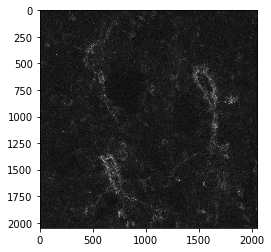

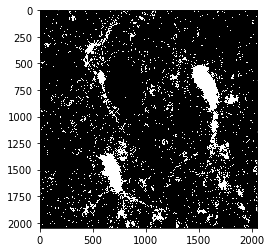

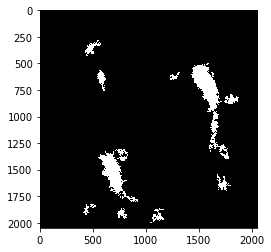

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

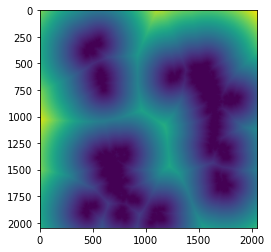

In [4]:
feat_df = PNN_binning(img, feat_df, min_obj_size=3000)

In [5]:
feat_df

[[3.2854808621577787, 0.3887686431165293],
 [],
 [4.158297722531733],
 [],
 [0.4088621296786024,
  1.4750142789875074,
  3.5059443727865567,
  1.8536146119210613,
  2.992078912734081,
  1.480515066433402,
  0.003397192878033657,
  0.7463165580015491,
  2.0851433995582256,
  2.3299782564871543,
  2.7674838395482872,
  3.0856199219953604],
 [1.5420212937068034,
  0.0008016647235760666,
  1.090886648222564,
  0.028056215270520792,
  1.7499761663080282,
  1.3853922614188183,
  0.0125,
  0.013372093023255812,
  0.010714285714285714,
  0.013636363636363636,
  0.012573099415204677,
  9.547157888718004,
  6.2169437469037625,
  3.904120728187789,
  0.7156319288355569],
 []]

In [ ]:
img.shape
imgplot = plt.imshow(img[0, :, :], cmap='gray')
plt.show()

In [ ]:
img = skimage.io.imread('HBSS_vid_3_z_stack_MaxIP.tif')
img.shape
imgplot = plt.imshow(img[0, :, :], cmap='gray')
plt.show()

In [ ]:
img_scaled = resize(img[0,:,:],(2048,2048))
scaled_plot = plt.imshow(img_scaled, cmap='gray')
plt.show()

In [ ]:
try_all_threshold(img_scaled, figsize=(20,18))

In [ ]:
# This performs threshold without using a preprocessing median filtering technique

thresh = skimage.filters.threshold_otsu(img_scaled)
pnnbinary = img_scaled > thresh
binaryplot = plt.imshow(pnnbinary, cmap='gray')
plt.show()

pnnbinary_filled = ndi.binary_fill_holes(pnnbinary)
binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
plt.show()

In [ ]:
from skimage import morphology

pnn_clean = morphology.remove_small_objects(pnnbinary_filled, min_size=3000)
pnn_clean_plot = plt.imshow(pnn_clean, cmap='gray')
plt.show()
binary_filledplot = plt.imshow(pnnbinary_filled, cmap='gray')
plt.show()
binaryplot = plt.imshow(pnnbinary, cmap='gray')
plt.show()

In [ ]:
from scipy.ndimage.morphology import distance_transform_edt as Euclidean

euc_img = Euclidean(1-pnn_clean) #1- represents going outwards from the cells
plt.imshow(euc_img)
plt.show

In [ ]:
import pandas as pd
bucket = 'mckenna.data'
remote_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
filename = "msd_{}.csv".format(prefix)
aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
local_name = filename
merged = pd.read_csv(local_name)

In [ ]:
merged[0:10]

In [ ]:
merged['Euc'] = np.nan
merged[0:10]

In [ ]:
import pandas as pd
bucket = 'mckenna.data'
remote_folder = '11_16_18_MPT_in_PNNs'
prefix = 'HBSS_vid_3'
filename = "features_{}.csv".format(prefix)
aws.download_s3(remote_folder+'/'+filename, filename, bucket_name=bucket)
feat_name = filename
feat_df = pd.read_csv(feat_name)

In [ ]:
feat_df
feat_df['Euc'] = np.nan
feat_df['Bin'] = np.nan
feat_df[0:10]

In [8]:
tot_traj = int(max(feat_df['Track_ID']))
one_count = 0
two_count = 0
three_count = 0
four_count = 0
five_count = 0
six_count = 0
seven_count = 0


for i in range(0,tot_traj+1):
    feat_df['Euc'][i] = euc_img[int(round(feat_df['X'][i])),int(round(feat_df['Y'][i]))]
    
    if feat_df['Euc'][i] == 0:
        feat_df['Bin'][i] = 1
        one_count = one_count+1
    elif feat_df['Euc'][i] <= 3.57: #250 nm
        feat_df['Bin'][i] = 2
        two_count = two_count+1
    elif feat_df['Euc'][i] <= 7.14: #500 nm
        feat_df['Bin'][i] = 3
        three_count = three_count+1
    elif feat_df['Euc'][i] <= 14.28: # 1 um
        feat_df['Bin'][i] = 4
        four_count = four_count+1
    elif feat_df['Euc'][i] <= 142.8: # 10 um
        feat_df['Bin'][i] = 5
        five_count = five_count+1
    elif feat_df['Euc'][i] <= 714.3: # 50 um
        feat_df['Bin'][i] = 6
        six_count = six_count+1
    else:
        feat_df['Bin'][i] = 7
        seven_count = seven_count+1

TypeError: list indices must be integers, not str

In [ ]:
print(one_count, two_count, three_count, four_count, five_count, six_count, seven_count)
print(int(max(one_count, two_count, three_count, four_count, five_count, six_count, seven_count)))

In [ ]:
feat_df

In [ ]:
int(max(feat_df['Track_ID']))
#feat_df['Bin'][0] == 5

In [ ]:
num_bins = 7
summary_array = np.zeros((int(max(one_count, two_count, three_count, four_count, five_count, six_count, seven_count)), int(num_bins)))

tot_traj = int(max(feat_df['Track_ID']))
count_one = 0
count_two = 0
count_three = 0
count_four = 0
count_five = 0
count_six = 0
count_seven = 0

for i in range(0,tot_traj+1):
    if feat_df['Bin'][i] == 1:
        summary_array[count_one, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_one = count_one + 1
    elif feat_df['Bin'][i] == 2:
        summary_array[count_two, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_two = count_two + 1
    elif feat_df['Bin'][i] == 3:
        summary_array[count_three, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_three = count_three + 1
    elif feat_df['Bin'][i] == 4:
        summary_array[count_four, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_four = count_four + 1
    elif feat_df['Bin'][i] == 5:
        summary_array[count_five, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_five = count_five + 1
    elif feat_df['Bin'][i] == 6:
        summary_array[count_six, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_six = count_six + 1
    else:
        summary_array[count_seven, int(feat_df['Bin'][i]) - 1] = feat_df['Deff1'][i]
        count_seven = count_seven + 1
    
print(summary_array)

masked_summary = ma.masked_where(summary_array == 0, summary_array)
plot_array = [[y for y in row if y] for row in masked_summary.T]
print(plot_array)



In [6]:
feat_df.plot(x = 'Bin', y = 'Deff1', style = 'o')

AttributeError: 'list' object has no attribute 'plot'

In [7]:
x = np.zeros(tot_traj+1)
y = np.zeros(tot_traj+1)

p = 0
for i in range(np.size(plot_array)):
    for j in range(len(plot_array[i])):
        x[p] = i+1
        y[p] = plot_array[i][j]
        p = p + 1

plt.subplot(211)
plt.boxplot(summary_array, sym = '')
plt.subplot(212)
plt.boxplot(plot_array, showfliers = False)
plt.plot(x,y,'k.')
plt.show()

NameError: name 'tot_traj' is not defined